In [1]:
from pathlib import Path
import numpy as np
import cv2 as cv
import supervision as sv
import matplotlib.pyplot as plt

In [2]:
PATH_MAT = Path("./material/")
PATH_WP = PATH_MAT / "white_patch"
PATH_RES = Path("./res")

for p in (PATH_MAT, PATH_WP, PATH_RES):
    assert p.exists() and p.is_dir(), f"Error when looking for path {p}"

# Parte 1: Imagenes en White Patch
1. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.
2. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de
White patch.

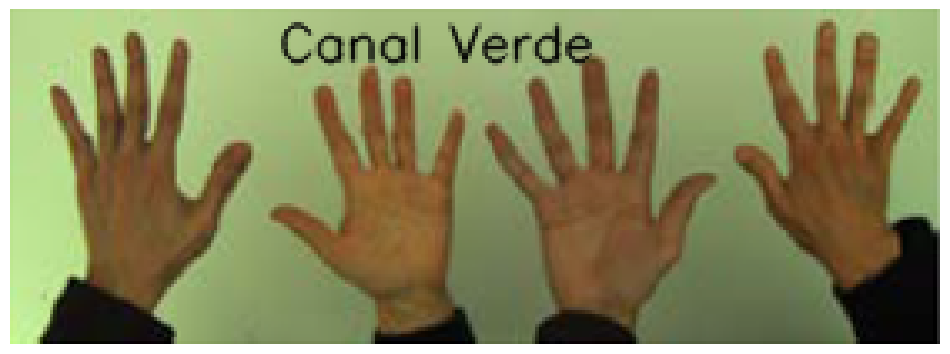

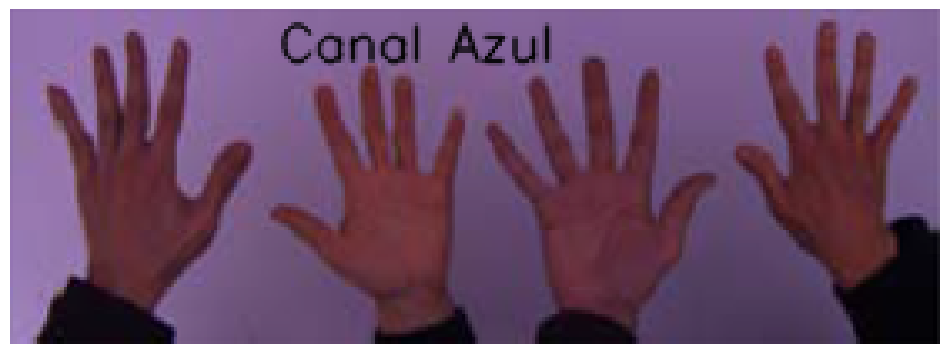

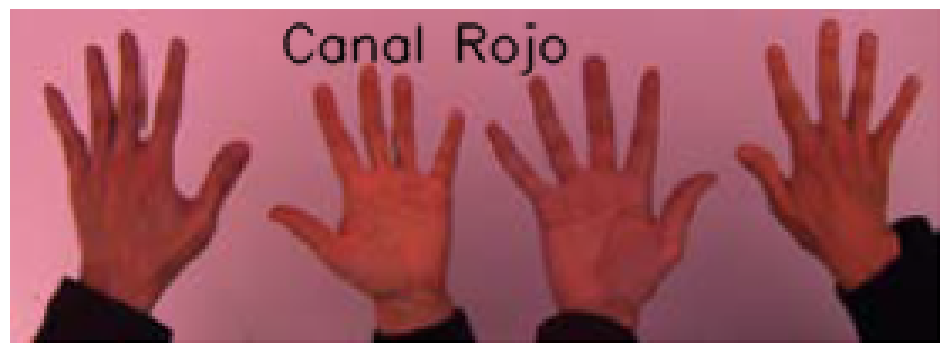

In [3]:
# Ejemplo de imagen     
fname = 'test_green.png' # Nombre del archivo de imagen que se va a cargar
fname1 = 'test_blue.png'
fname2 = 'test_red.png'
img = cv.imread(PATH_WP / fname) # Lee la imagen usando OpenCV desde la ruta combinada PATH_WP / fname
img1 = cv.imread(PATH_WP / fname1)
img2 = cv.imread(PATH_WP / fname2)

# Función para agregar título sobre una imagen
def agregar_titulo(imagen, texto):
    return cv.putText(
        imagen.copy(),
        texto,
        org=(80, 15),  # posición del texto
        fontFace=cv.FONT_HERSHEY_SIMPLEX,
        fontScale=0.5,
        color=(0, 0, 0),  # negro
        thickness=1,
        lineType=cv.LINE_AA
    )

# Agregar títulos a cada imagen
img_titulo = agregar_titulo(img, "Canal Verde")
img1_titulo = agregar_titulo(img1, "Canal Azul")
img2_titulo = agregar_titulo(img2, "Canal Rojo")

# Mostrar con supervision
sv.plot_image(img_titulo)
sv.plot_image(img1_titulo)
sv.plot_image(img2_titulo)

In [4]:
# implementación de algoritmo white patch
# https://en.wikipedia.org/wiki/White_patch
def white_patch(img: np.ndarray, q: float = 0.95) -> np.ndarray:
    """
    Funcion que aplica corrección White Patch a una imagen RGB usando un cuantil (quantile)
    en lugar del valor máximo, para cada canal de color.

    Args:
        img (np.ndarray): Imagen RGB como array de NumPy con forma (alto, ancho, 3) y tipo uint8.
        q (float): Cuantil por canal para normalizar (entre 0 y 1). Por defecto 0.95.

    Returns:
        np.ndarray: Imagen corregida (mismo tamaño y tipo de dato).
    """
    assert img.ndim == 3 and img.shape[2] == 3, "La imagen debe ser RGB (m,n,3)"
        
    # Se obtiene cuantiles por canal (eje 0 y 1 - altura y ancho), manteniendo forma
    qs = np.quantile(img, q, axis=(0, 1), keepdims=True)

    # Se escala cada pixel dividiendo por el cuantil y multiplicando por 255
    qs[qs == 0] = 1  # para evitar dividir por cero si un canal es todo negro
    res = img * (255.0 / qs)

    # Se recortan valores para evitar desbordes (uint8 solo permite 0-255)
    res = res.clip(0, 255)

    # Se convierte de nuevo a uint8 para mantener compatibilidad con OpenCV
    return res.astype(img.dtype)


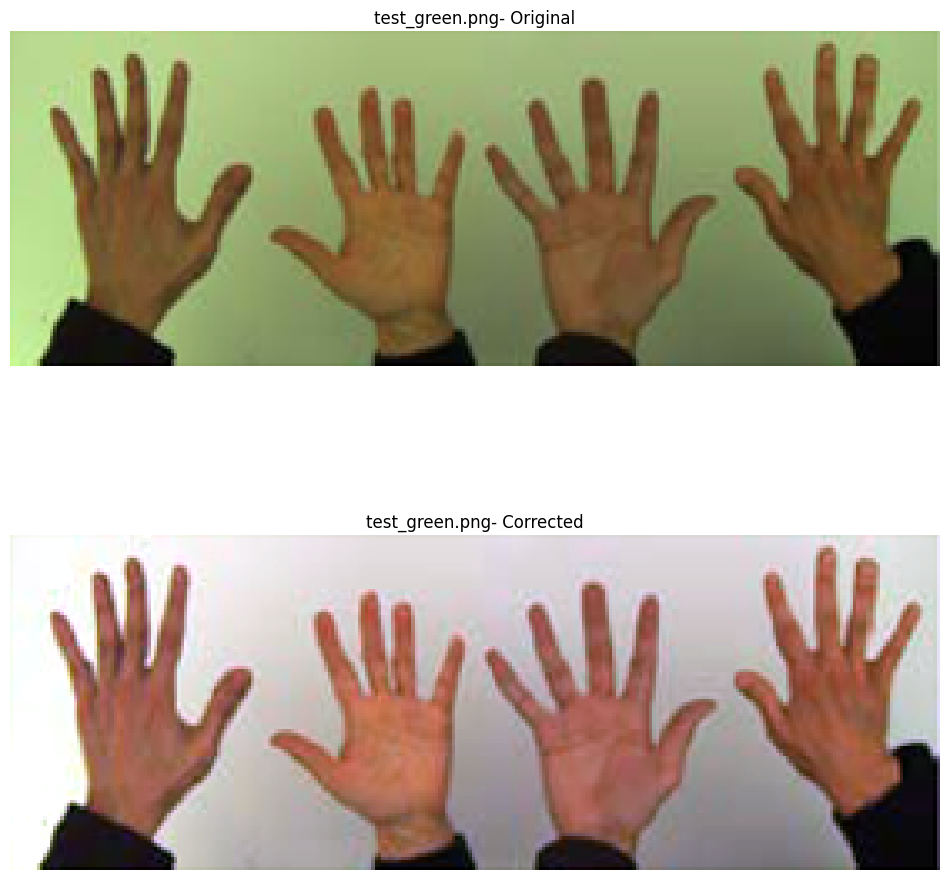

In [5]:
# Implementación del algoritmo White Patch en la imagen test_green.png
corrected_img = white_patch(img, 0.95)

sv.plot_images_grid(
    [img, corrected_img],
    grid_size=(2,1),
    titles = [fname + f"- {kind}" for kind in ('Original', 'Corrected')]
)

Comentarios: Para este ejemplo el resultado obtenido es muy bueno.

In [6]:
# Generamos resultados para tres valores diferentes de q
# 0.9 y 0.95 son los principales; 1 es solo de referencia
Q_GRID = (0.9, 0.95, 1)

for q in Q_GRID:
    # Se crea carpeta de resultados para cada q si no existe
    res_path_q = PATH_RES / f"q_{q}"
    if not res_path_q.exists():
        res_path_q.mkdir()

    # Se Procesa cada imagen en el directorio PATH_WP
    for p in PATH_WP.iterdir():
        fname = p.name

        # Se Carga imagen
        img = cv.imread(str(p))

        if img is None:
            print(f"No se pudo leer la imagen: {p}")
            continue

        # Se aplica white patch con el valor de q actual
        corrected_img = white_patch(img, q)

        # Se guarda imagen corregida en carpeta de resultados
        cv.imwrite(str(res_path_q / fname), corrected_img)


A continuación se presentan dos ejemplos ilustrativos. Las observaciones realizadas en estos casos son consistentes con el comportamiento observado en el resto del conjunto de imágenes corregidas, las cuales se encuentran organizadas en la carpeta /res, dentro de las subcarpetas correspondientes a cada valor de cuantil.

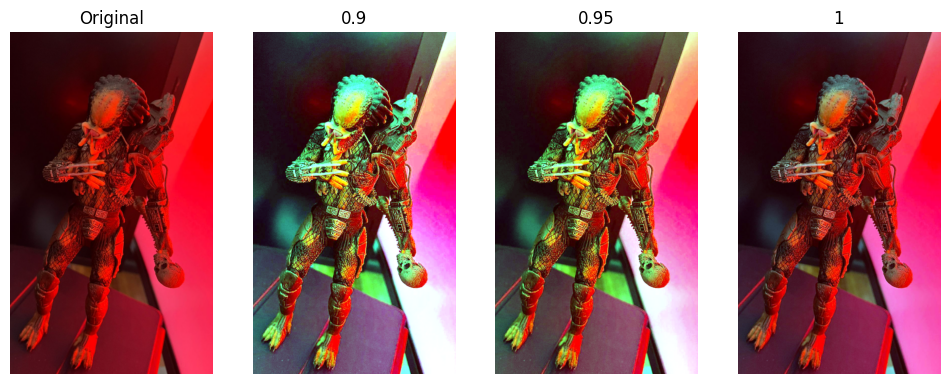

In [7]:
# mostramos uno de los predator
fname = 'wp_red.png'

img = cv.imread(PATH_WP / fname)

corrections = {
    q:cv.imread(PATH_RES / f"q_{q}" / fname)
    for q in Q_GRID
}

sv.plot_images_grid(
    [img] + list(corrections.values()),
    grid_size=(1,len(corrections)+1),
    titles=['Original']+list(str(q) for q in corrections.keys())
)

Si bien el resultado no es perfecto, es bastante bueno. Algunas zonas, como la cabeza del predator, se ponen un poco rojas para `q=0.9`.

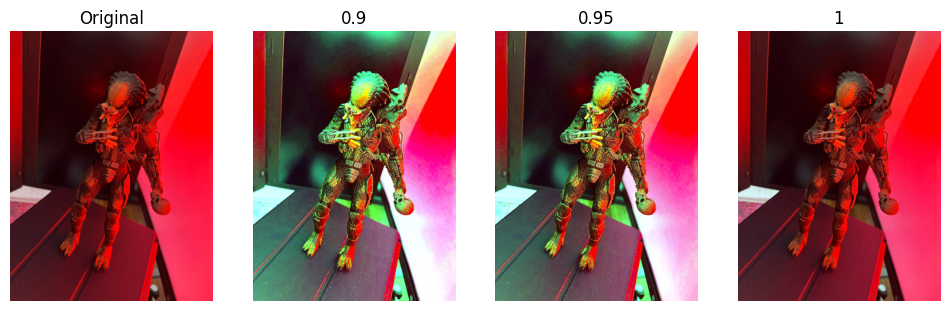

In [8]:
# la versión 2
fname = 'wp_red2.jpg'

img = cv.imread(PATH_WP / fname)

corrections = {
    q:cv.imread(PATH_RES / f"q_{q}" / fname)
    for q in Q_GRID
}

sv.plot_images_grid(
    [img] + list(corrections.values()),
    grid_size=(1,len(corrections)+1),
    titles=['Original']+list(str(q) for q in corrections.keys())
)

Vemos que en estos casos el algoritmo no funciona bien. Aparecen manchas de color que había antes en las imágenes pero que ahora resultan exageradas, especialmente para valores más bajos de `q`. Por otra parte, utilizar `q=1` no ayuda en nada.

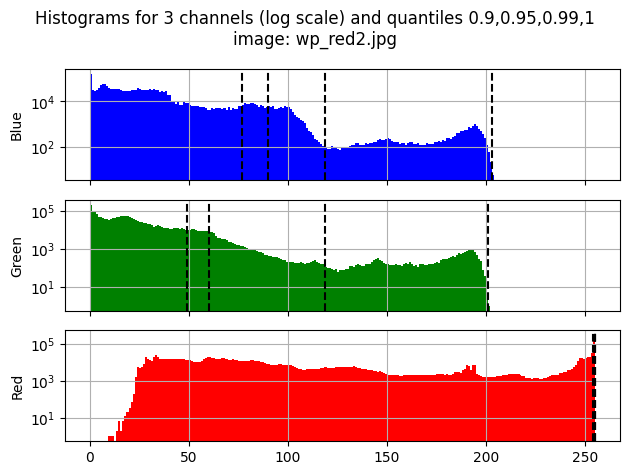

In [10]:
# observamos histograma por canal de original
fig, axes =  plt.subplots(nrows=3, sharex=True)

plot_qs = [0.9, 0.95, 0.99, 1]

for idx,(ax, color) in enumerate(zip(axes, ('Blue','Green','Red'))):
    data = img[:,:,idx].flatten()
    ax.hist(data, bins=range(256), log=True, color=color)
    ax.grid(True)
    #ax.set_title(color)
    lims = ax.get_ylim()
    ax.vlines(np.quantile(data, plot_qs),*lims, 
              color='black', linestyle='dashed')
    ax.set_ylabel(color)
    ax.set_ylim(*lims)

fig.suptitle(
    "".join(['Histograms for 3 channels (log scale) ',
             f"and quantiles {",".join(str(x) for x in plot_qs)}",
             "\n"
             f"image: {fname}",
]))
plt.tight_layout()

En ambos casos, azul y rojo, las distribuciones presentan cuantiles altos considerablemente alejados del valor máximo, lo que conduce a una saturación en las regiones de mayor concentración. Este comportamiento sugiere que enfoques de normalización locales, en contraposición a métodos globales, podrían mejorar el desempeño del procesamiento. No obstante, esta posibilidad no se aborda en el alcance del presente estudio.

# Parte 2: Histogramas
Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grisas y
visualizarlas.

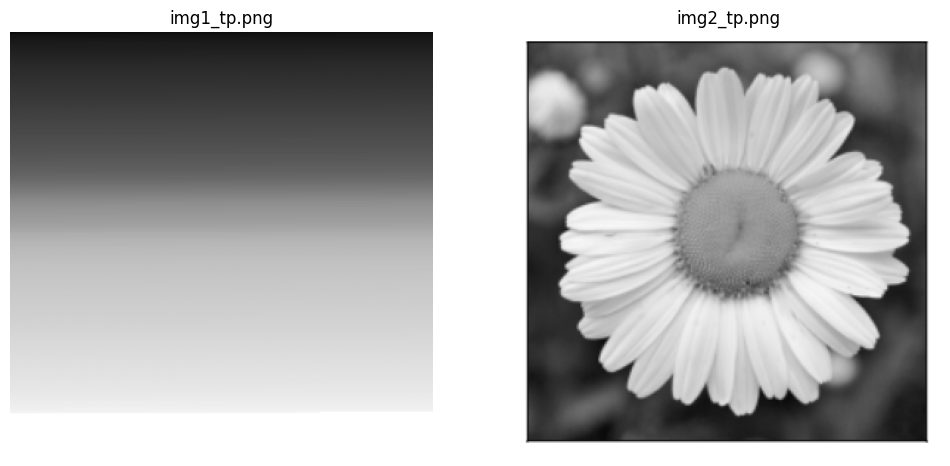

In [11]:
# levantamos ambas imagenes
names = [f"img{i}_tp.png" for i in (1,2)]
imgs = [
    cv.imread(PATH_MAT / fname, cv.IMREAD_GRAYSCALE)
    for fname in names
]

sv.plot_images_grid(
    imgs,
    grid_size=(1,2),
    titles=names
)

Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas
entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección
de imágenes, considera que puede ser de utilidad tomar como ‘features’ a los histogramas?

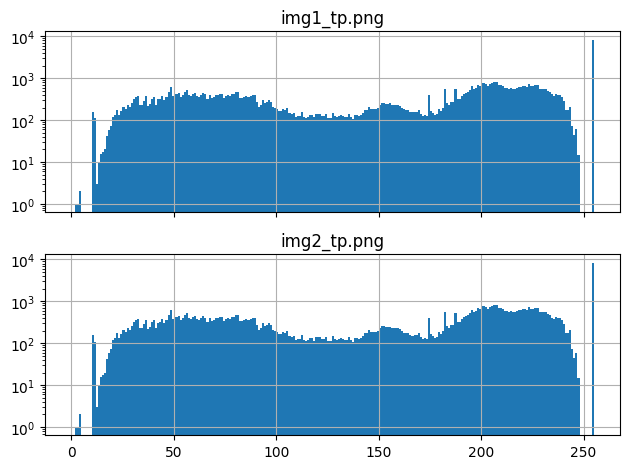

In [12]:
# mostramos sus histogramas

# como base usamos 256 bins, i.e. todos los valores posibles

fig, axes =  plt.subplots(nrows=2, sharex=True)

for ax, fname, img in zip(axes, names, imgs):
    ax.hist(img.flatten(), bins=range(256), log=True)
    ax.grid(True)
    ax.set_title(fname)


plt.tight_layout()

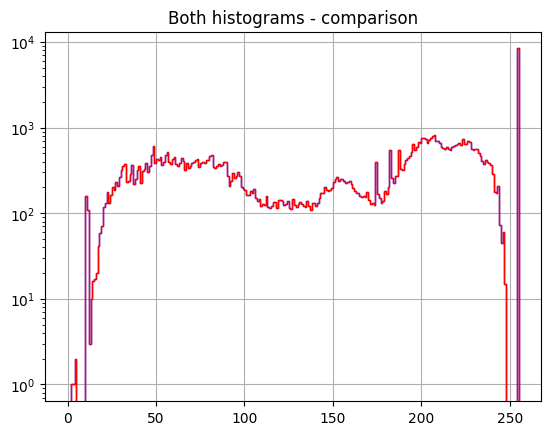

In [13]:
# para mayor impacto, los ploteamos sobre el mismo plano
fig, ax = plt.subplots()

for img, color in zip(imgs, ('blue','red')):
    ax.hist(img.flatten(), bins=range(256), log=True, color=color,
            histtype='step')
ax.grid(True)
ax.set_title("Both histograms - comparison")
plt.show()

Como se puede apreciar, tienen una distribución de valores idéntica. En este caso no resultaría de utilidad usar el histograma para un modelo predictivo que intente distinguir una imagen de la otra. 

Como observación extra, la imagen de la izquierda es artificial mientras que la de la derecha no. Es razonable considerar que la primera es un ejemplo de ataque _adversarial_ y que dependiendo de las condiciones en las que se despliegue el modelo tal construcción podría no ser posible.

## 